# GR Comparison


In [1]:
import rebound
import reboundx
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [53]:
def extraEnergy(sim, gr):
    if gr is None:
        return 0.
    e = 0.
    ps = sim.particles
    sun = ps[0]
    C = 10064.915
    for i,p in enumerate(ps):
        if i>0:
            dx = p.x - sun.x
            dy = p.y - sun.y
            dz = p.z - sun.z
            r2 = dx*dx + dy*dy + dz*dz
            e += 1./(C*C)*(sim.G*sun.m)**2*p.m/(2.*r2)
            
            dvx = p.vx - sun.vx
            dvy = p.vy - sun.vy
            dvz = p.vz - sun.vz
            v2 = dvx*dvx + dvy*dvy + dvz*dvz
            e -= 1./(C*C)*(v2*v2*p.m/8.)
            
            e -= 1./(C*C)*3./2.*sim.G*sun.m*v2*p.m/np.sqrt(r2)
    return e
    
def runSS(gr=None):  
    sim = rebound.Simulation.from_file("initial-gr-ss.bin")
    sim.integrator = "ias15"
    sim.move_to_com()
    
    e0e = extraEnergy(sim, gr)
    e0 = sim.calculate_energy()

    if gr is not None:
        xs = reboundx.Extras(sim)
        methodToCall = getattr(xs, gr)
        methodToCall()

    N = 1000
    times = np.linspace(1,2.*np.pi*1e2,N)
    es = np.zeros((N,2))
    for i, t in enumerate(times):
        
        sim.integrate(t,exact_finish_time=1)
        e1e = extraEnergy(sim, gr)
        e1 = sim.calculate_energy()
        es[i] = (np.fabs((e1-e0)/e0), np.fabs((e1e-e0e)/e0))
    
    return times, es

In [54]:
modules = [None, "add_gr", "add_gr_potential", "add_gr_implicit"]

results = []
for m in modules:
    start = time.time()
    res = runSS(m)
    end = time.time()
    results.append(res)
    print("%s:   %.5fs"%(m,end-start))
    

None:   1.22545s
add_gr:   1.50794s
add_gr_potential:   1.31050s
add_gr_implicit:   4.58588s


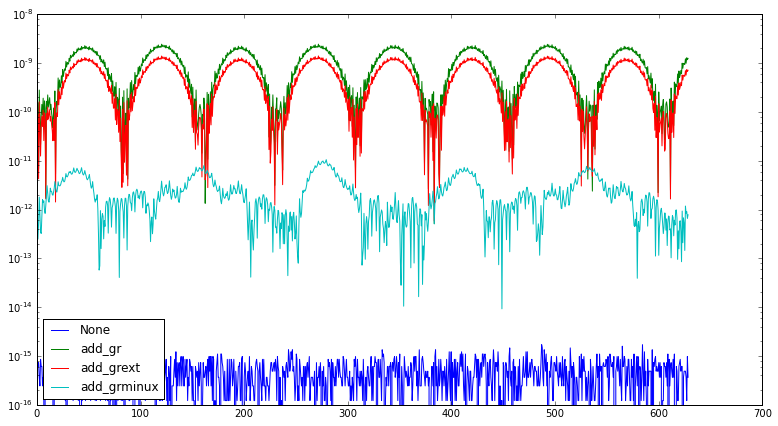

In [65]:
fig = plt.figure(figsize=(13,7))
ax = plt.subplot(111)
ax.set_yscale("log")

for i, m in enumerate(modules):
    label = m
    if m is None:
        label = "None"
    if m is None:
        plt.plot(results[i][0],results[i][1][:,0], label=label)
    if m is "add_gr":
        plt.plot(results[i][0],results[i][1][:,0], label=label)
        plt.plot(results[i][0],results[i][1][:,1], label=label+"ext")
        plt.plot(results[i][0],np.fabs(results[i][1][:,0]-1.75*results[i][1][:,1]), label=label+"minux")



plt.legend(loc='lower left')

In [23]:
sim = rebound.Simulation.from_file("initial-gr-ss.bin")
sim.integrator = "ias15"
sim.move_to_com()


print sim.calculate_energy(), extraEnergy(sim, "sdf")
print (sim.calculate_energy()/ extraEnergy(sim, "sdf"))**(-1)



-0.00011114369166 -4.65994063355e-13
4.19271716097e-09
